# Hash model
- http://users.eecs.northwestern.edu/~jwa368/pdfs/deep_ranking.pdf
- https://papers.nips.cc/paper/4808-hamming-distance-metric-learning.pdf
- https://arxiv.org/pdf/1702.00758.pdf
- face net: https://arxiv.org/pdf/1503.03832.pdf

In [1]:
# TODO: 
# - try arc from:
#   - http://users.eecs.northwestern.edu/~jwa368/pdfs/deep_ranking.pdf
#   - https://arxiv.org/pdf/1503.03832.pdf
# - normalize images before augment for training, before building database and before searching
# - add batch normalization https://habrahabr.ru/company/wunderfund/blog/315476/
# - add dropouts

In [1]:
import tensorflow as tf
import numpy as np
from dataset import TripletDataset
from coin_base import DataBase
from augmentator import Augmentator
from visualisation import show_losses, show_similarity

In [2]:
class Model():
    def __init__(self, image_shape, out_dims, metric):
        assert metric=='hamming' or metric=='euclidean'
        self.image_shape = image_shape
        self.out_dims    = out_dims
        self.metric      = metric
        self._session    = None
        self._graph      = None
        self.scope       = 'embedding_' + metric
        
    def _make_nn(self, images, out_dim, reuse):
        def conv2d_maxpool(inputs, filters, name, reuse, kernel_size=[3,3], padding="same", activation=tf.nn.relu):
            l = tf.layers.conv2d(
                inputs      = inputs,
                filters     = filters,
                kernel_size = kernel_size,
                padding     = padding,
                activation  = tf.nn.relu,
                reuse       = reuse,
                name        = name
            )
            l = tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
            return l
        l = images                                              # 128 x 128 x 1
        l = conv2d_maxpool(l, 16,  reuse=reuse, name='conv1')   #  64 x 64  x 16
        l = conv2d_maxpool(l, 32,  reuse=reuse, name='conv2')   #  32 x 32  x 32
        l = conv2d_maxpool(l, 64,  reuse=reuse, name='conv3')   #  16 x 16  x 64
        l = conv2d_maxpool(l, 128, reuse=reuse, name='conv4')   #   8 x 8   x 128
        l = conv2d_maxpool(l, 256, reuse=reuse, name='conv5')   #   4 x 4   x 256 = 4096
        l = tf.contrib.layers.flatten(l)
        l = tf.layers.dense(l, units=4096, activation=tf.nn.relu, reuse=reuse, name='fc1')
        l = tf.layers.dense(l, units=out_dim, reuse=reuse, name='logits')
        
        if self.metric == 'hamming':
            l = tf.nn.tanh(l*100)
        elif self.metric == 'euclidean':
            l = tf.nn.l2_normalize(l, dim=1)
        return l

    def _make_loss(self, main, same, diff, margin):
        def hamming_distance(a, b):
            prod = tf.reduce_sum(tf.multiply(a, b), axis=1)
            dist = (self.out_dims - prod)/2
            return dist
        def euclidean_distance(a, b):
            dist = tf.reduce_sum((a-b)**2, axis=1)
            return dist
        
        if self.metric == 'hamming':
            dist = hamming_distance
        elif self.metric == 'euclidean':
            dist = euclidean_distance
            
        pos_dist = dist(main, same)
        neg_dist = dist(main, diff)
        loss = tf.nn.relu(pos_dist - neg_dist + margin)
        loss = tf.reduce_mean(loss)
        return loss

    def build(self):
        tf.reset_default_graph()
        self._graph = tf.Graph()
        img_shape = self.image_shape
        with self._graph.as_default(), tf.variable_scope(self.scope), tf.device('/gpu:0'):
            # placeholders
            self.img_main_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+img_shape, name='main_img')
            self.img_same_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+img_shape, name='same_img')
            self.img_diff_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+img_shape, name='diff_img')
            self.margin_pl   = tf.placeholder(dtype=tf.float32, name='margin')
            self.b_pl        = tf.placeholder(dtype=tf.float32, name='b')
            self.lr_pl       = tf.placeholder(dtype=tf.float32, name='lr')
            # network
            self.nn_main   = self._make_nn(self.img_main_pl, self.out_dims, reuse=False)
            self.nn_same   = self._make_nn(self.img_same_pl, self.out_dims, reuse=True)
            self.nn_diff   = self._make_nn(self.img_diff_pl, self.out_dims, reuse=True)
            # operations
            self.loss_op   = self._make_loss(self.nn_main, self.nn_same, self.nn_diff, self.margin_pl)
            self.train_op  = tf.train.AdamOptimizer(self.lr_pl).minimize(self.loss_op)
            self.init_op   = tf.global_variables_initializer()
            
        self._session = tf.Session(graph=self._graph)
        self._session.run(self.init_op)
        
    def train(self, dataset, step_num, batch_size, margin, lr, aug, log_every=10, mean_win=100):
        try:
            losses = []
            for step in range(step_num):
                img_main, img_same, img_diff = dataset.get_next_batch(batch_size)
                _, loss = self._session.run([self.train_op, self.loss_op], feed_dict={
                    self.img_main_pl: aug(img_main),
                    self.img_same_pl: aug(img_same),
                    self.img_diff_pl: aug(img_diff),
                    self.margin_pl:   margin,
                    self.lr_pl:       lr,
                })
                losses.append(loss)
                if step % log_every == log_every-1:
                    show_losses(losses, step, step_num, mean_win)
        except KeyboardInterrupt:
            pass
        show_losses(losses, step, step_num, mean_win)

    def save(self, path):
        with self._graph.as_default(), tf.variable_scope(self.scope):
            saver = tf.train.Saver()
        saver.save(self._session, path)
        
    def restore(self, path):
        with self._graph.as_default(), tf.variable_scope(self.scope):
            saver = tf.train.Saver()
        saver.restore(self._session, path)        
    
    def run(self, imgs, batch_size=100, b=100):
        outputs = np.zeros(shape=[len(imgs), self.out_dims])
        bs = min(len(imgs), batch_size)
        for i in range(len(imgs)//bs):
            batch = imgs[i*bs:(i+1)*bs,:]
            outputs[i*bs:(i+1)*bs,:] = self._session.run(self.nn_main, feed_dict = {
                self.img_main_pl : batch,
                self.b_pl : b,
            })
        return outputs

## Create model

In [3]:
%%time
image_shape  = [128,128,1]
tr_data_size = 1000
te_data_size = 1000
out_dims     = 128
margin       = .2
metric       = 'euclidean' # euclidean / hamming
data_path    = "/netforge/datasets/private/roman/coins/images"

tr_dataset   = TripletDataset(image_shape)
te_dataset   = TripletDataset(image_shape)
tr_dataset.load(data_path, tr_data_size)
te_dataset.load(data_path, te_data_size)

model = Model(image_shape, out_dims, metric)
model.build()

tr_aug = Augmentator(
    cache_size = 300, 
    rate       = 1)

CPU times: user 19.2 s, sys: 872 ms, total: 20 s
Wall time: 20.1 s


## Train model

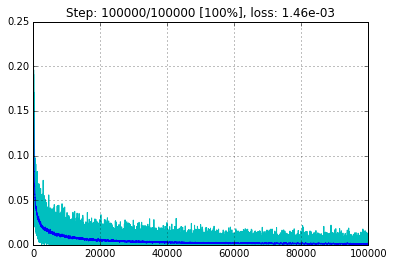

CPU times: user 5h 58min 10s, sys: 1h 2min 46s, total: 7h 56s
Wall time: 6h 19min 58s


In [10]:
%%time
model.train(
    dataset    = tr_dataset,
    aug        = tr_aug.augment,https://arxiv.org/pdf/1503.03832.pdf
    margin     = margin,
    step_num   = 100000, 
    batch_size = 64, 
    lr         = 3e-6)
model.save("models/hash_model/001/")

## Test quality

In [33]:
%%time
dbase = DataBase()
dbase.build(model, te_dataset.test_images, model.metric)
te_aug  = Augmentator(rate=.60)
request = te_aug.augment(dbase.images)

CPU times: user 6.79 s, sys: 56 ms, total: 6.85 s
Wall time: 6.9 s


In [34]:
%%time
ind, dist  = dbase.query(request, 3)

def get_quality(ind, k):
    assert 0 < k <= ind.shape[1]
    err = 0
    N   = len(ind)
    for i in range(N):
        ok = False
        for j in range(k):
            if i==ind[i,j]:
                ok = True
        err+= not ok
    return ((N-err)/N*100)

print("Images   : %s" % list(dbase.images.shape))
print("Aug reate: %.2f" % te_aug._rate)
for k in range(1, ind.shape[1]+1):
    print("Quality@%d: %.1f%%" % (k, get_quality(ind, k)))
print('-'*50)

Images   : [1000, 128, 128, 1]
Aug reate: 0.60
Quality@1: 94.8%
Quality@2: 99.3%
Quality@3: 99.8%
--------------------------------------------------
CPU times: user 356 ms, sys: 8 ms, total: 364 ms
Wall time: 499 ms


Search known augmented coins:
average distance: 0.47


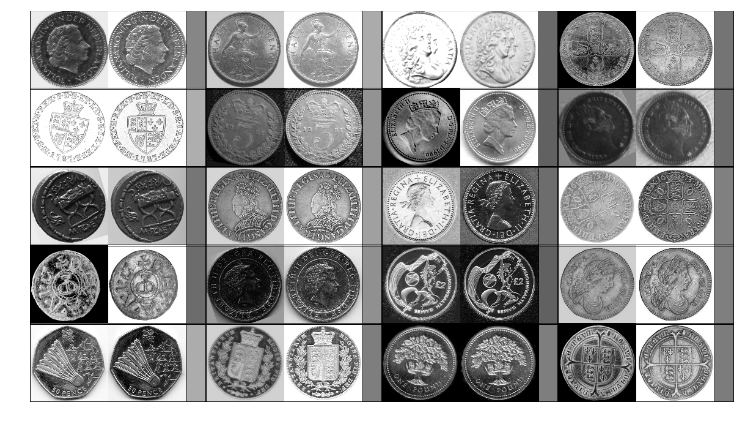

In [36]:
def show_results(images, max_k=0, aug=True):
    if aug:
        request = te_aug.augment(images)
    else:
        request = np.copy(images)
    ind, dist  = dbase.query(request, 3)
    per = np.random.choice(range(len(ind)), len(ind), replace=False)
    im1 = request[per]
    for k in range(0, max_k+1):
        print("average distance: %.2f" % np.mean(dist[:,k]))
        im2 = dbase.images[ind[:,k]][per]
        sim = 1-dist[:,k][per]
        num = 20
        im1 = im1[:num]
        im2 = im2[:num]
        sim = sim[:num]
        show_similarity(im1, im2, sim, cols=4)

print("Search known augmented coins:")
show_results(dbase.images)

Search unknown coins:
average distance: 0.63


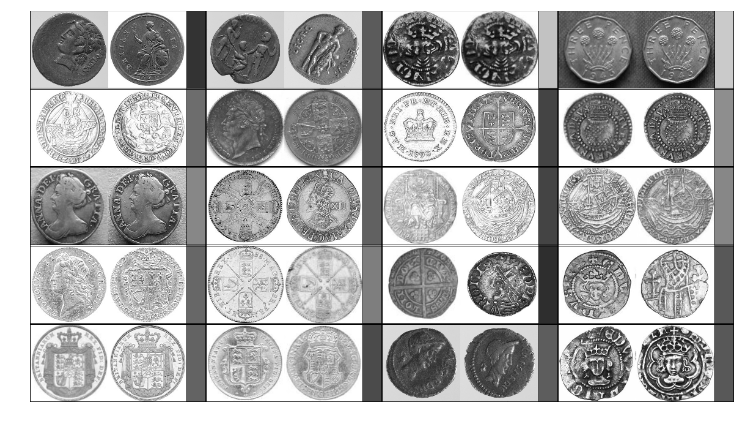

average distance: 0.70


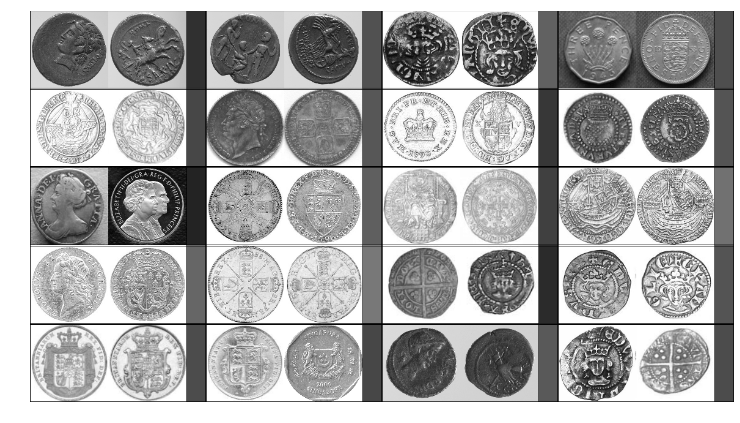

In [38]:
print("Search unknown coins:")
show_results(tr_dataset.train_images, max_k=1, aug = False)

## Restore model

In [4]:
model.restore("models/hash_model/001/")

INFO:tensorflow:Restoring parameters from models/hash_model/001/
